# Keras tutorial - the Happy House

In this notebook we will:

1. Learn to use Keras, a high-level neural networks API (programming framework), written in Python and capable of running on top of several lower-level frameworks including TensorFlow and CNTK. 
2. See how we can build a deep learning algorithm in a couple of hours.

Why are we using Keras? Keras was developed to enable deep learning engineers to build and experiment with different models very quickly. Just as TensorFlow is a higher-level framework than Python, Keras is an even higher-level framework and provides additional abstractions. Being able to go from idea to result with the least possible delay is key to finding good models. However, Keras is more restrictive than the lower-level frameworks, so there are some very complex models that you can implement in TensorFlow but not (without more difficulty) in Keras. That being said, Keras will work fine for many common models. 

Below, we'll work on the "Happy House" problem, which is explained below. Let's load the required packages and solve the problem of the Happy House!

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
# import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

Using TensorFlow backend.


**Note**: As you can see, we've imported a lot of functions from Keras. We can use them easily just by calling them directly in the notebook. Ex: `X = Input(...)` or `X = ZeroPadding2D(...)`.

## 1 - The Happy House 

For our next vacation, we decided to spend a week with five of our friends from school. It is a very convenient house with many things to do nearby. But the most important benefit is that everybody has commited to be happy when they are in the house. So anyone wanting to enter the house must prove their current state of happiness.

<img src="images/happy-house.jpg" style="width:350px;height:270px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **the Happy House**</center></caption>


As a deep learning expert, to make sure the "Happy" rule is strictly applied, we are going to build an algorithm which that uses pictures from the front door camera to check if the person is happy or not. The door should open only if the person is happy. 

We have gathered pictures of our friends and ourself, taken by the front-door camera. The dataset is labled. 

<img src="images/house-members.png" style="width:550px;height:250px;">

Let's normalize the dataset and learn about its shapes.

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


**Details of the "Happy" dataset**:
- Images are of shape (64,64,3)
- Training: 600 pictures
- Test: 150 pictures

It is now time to solve the "Happy" Challenge.

## 2 - Building a model in Keras

Keras is very good for rapid prototyping. In just a short time we will be able to build a model that achieves outstanding results.

Here is an example of a model in Keras:

```python
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates the Keras model instance, we'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model
```

Note that Keras uses a different convention with variable names than we've previously used with numpy and TensorFlow. In particular, rather than creating and assigning a new variable on each step of forward propagation such as `X`, `Z1`, `A1`, `Z2`, `A2`, etc. for the computations for the different layers, in Keras code each line above just reassigns `X` to a new value using `X = ...`. In other words, during each step of forward propagation, we are just writing the latest value in the commputation into the same variable `X`. The only exception was `X_input`, which we kept separate and did not overwrite, since we needed it at the end to create the Keras model instance (`model = Model(inputs = X_input, ...)` above). 

Let's implement a `HappyModel()`.  

In [3]:
def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates our Keras model instance.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model

We have now built a function to describe our model. To train and test this model, there are four steps in Keras:
1. Create the model by calling the function above
2. Compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`
3. Train the model on train data by calling `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`
4. Test the model on test data by calling `model.evaluate(x = ..., y = ...)`

More about `model.compile()`, `model.fit()`, `model.evaluate()` and their arguments, can be found in the official [Keras documentation](https://keras.io/models/model/).

Step 1, i.e. create the model.

In [4]:
happyModel = HappyModel((64,64,3))

Instructions for updating:
Colocations handled automatically by placer.


Implement step 2, i.e. compile the model to configure the learning process. 

In [5]:
happyModel.compile(optimizer = "adam",loss = "binary_crossentropy",metrics = ["accuracy"])

Implement step 3, i.e. train the model. Choose the number of epochs and the batch size.

In [6]:
happyModel.fit(x = X_train, y = Y_train, epochs =40, batch_size = 16)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
600/600 [==============================] - 7s 11ms/step - loss: 0.9834 - acc: 0.7150
Epoch 2/40
600/600 [==============================] - 5s 8ms/step - loss: 0.2305 - acc: 0.8950
Epoch 3/40
600/600 [==============================] - 4s 7ms/step - loss: 0.1349 - acc: 0.9533
Epoch 4/40
600/600 [==============================] - 4s 7ms/step - loss: 0.1871 - acc: 0.9333
Epoch 5/40
600/600 [==============================] - 4s 7ms/step - loss: 0.1046 - acc: 0.9617
Epoch 6/40
600/600 [==============================] - 5s 8ms/step - loss: 0.1046 - acc: 0.9583
Epoch 7/40
600/600 [==============================] - 4s 7ms/step - loss: 0.0726 - acc: 0.9750
Epoch 8/40
600/600 [==============================] - 4s 7ms/step - loss: 0.1694 - acc: 0.9300
Epoch 9/40
600/600 [==============================] - 4s 7ms/step - loss: 0.0709 - acc: 0.9767
Epoch 10/40
600/600 [==============================] - 5s 8ms/step - loss: 0.0580 - acc: 0.9783


Note that if we ran `fit()` again, the `model` would continue to train with the parameters it has already learnt instead of reinitializing them.

Implement step 4, i.e. test/evaluate the model.

In [7]:
preds = happyModel.evaluate(x = X_test,y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 1s 7ms/step

Loss = 0.11130234698454539
Test Accuracy = 0.9599999976158142


Our `happyModel()` function worked, acheiving over 97% accuracy on the test set!.

## 3 - Conclusion

We have solved the Happy House challenge! 

**Things to remember:**
- Keras is a tool we recommend for rapid prototyping. It allows us to quickly try out different model architectures. 
- The four steps leading to the evaluation of your model on the test set: Create->Compile->Fit/Train->Evaluate/Test.

## 4 - Testing with an external image
    
The training/test sets were quite similar; for example, all the pictures were taken against the same background (since a front door camera is always mounted in the same position). This makes the problem easier, but a model trained on this data may or may not work on different data. let's try anyway though.

Note that the below keeps crashing the notebook on my local machine for some reason but works on Google Colab.

In [8]:
"""
img_path = 'images/happy.JPG'


img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happyModel.predict(x))
"""

"\nimg_path = 'images/happy.JPG'\n\n\nimg = image.load_img(img_path, target_size=(64, 64))\nimshow(img)\n\nx = image.img_to_array(img)\nx = np.expand_dims(x, axis=0)\nx = preprocess_input(x)\n\nprint(happyModel.predict(x))\n"

## 5 - Other useful functions in Keras (Optional)

Two other basic features of Keras that are useful are:
- `model.summary()`: prints the details of the layers in a table with the sizes of its inputs/outputs
- `plot_model()`: plots the graph in a nice layout. This can even be saved as ".png" using SVG().

In [9]:
happyModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
__________

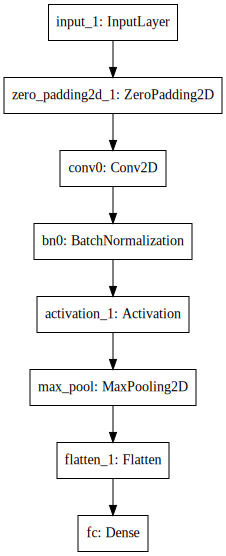

In [10]:
plot_model(happyModel, to_file='HappyModel.png')
SVG(model_to_dot(happyModel).create(prog='dot', format='svg'))